<a href="https://colab.research.google.com/github/SheikhMudassarHanif/NLP/blob/main/TextTranslationRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**I Will be Implementing text translation using Simple RNN and LSTM and compare their performance**

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#
# import tensorflow as tf
# from tensorflow import keras

In [93]:

excel_file_path = '/content/parallel-corpus.xlsx'
column_names = pd.read_excel(excel_file_path, nrows=0).columns.tolist()
df = pd.read_excel(excel_file_path,usecols=[column_names[0],column_names[1]])
df.dropna(inplace=True)
df.head()

,SENTENCES,MEANING
0,How can I communicate with my parents?,میں اپنے والدین سے کیسے بات کروں ؟
1,How can I make friends?’,میں دوست کیسے بنائوں ؟
2,Why do I get so sad?’,میں اتنا اداس کیوں ہوں؟.
3,"If you’ve asked yourself such questions, you’r...",اگر آپ نے اپنے آپ سے ایسے سوالات کیے ہیں، تو آ...
4,"Depending on where you’ve turned for guidance,...",اس بات پر منحصر ہے کہ آپ رہنمائی کے لیے کہاں ...


In [94]:
df.tail()

,SENTENCES,MEANING
30159,Tasty food nice environment everyone should vi...,لذیذ کھانا اچھا ماحول ہر کسی کو دوستوں اور کنب...
30160,Thumbs up,بہت خوب
30161,Food was awesome,کھانا لاجواب تھا۔
30162,Economical place with a great taste. A tough c...,ایک عظیم ذائقہ کے ساتھ اقتصادی جگہ. کراچی میں ...
30163,Food was good but service was very slow.,کھانا اچھا تھا لیکن سروس بہت سست تھی۔


In [95]:
train,val,test=np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [96]:
len(train),len(val),len(test)

(23693, 2962, 2962)

In [97]:
import re
from LughaatNLP import LughaatNLP
urdu_text_processing = LughaatNLP()

In [79]:

# def Normalize_label(text):
#     # Check if the input is not a string
#     if not isinstance(text, str):
#         text = str(text)
#           # Convert it to a string
#         urdu_text_processing.remove_special_characters_exceptUrdu(text)
#         urdu_text_processing.remove_special_characters(text)
#         urdu_text_processing.pure_urdu(text)
#         urdu_text_processing.remove_diacritics(text)
#         urdu_text_processing.punctuations_space(text)
#         text = re.sub(r'[.,!?؟،؛,]', '', text)
#     return urdu_text_processing.normalize(text)


In [98]:
import re

def Normalize_label(text):
    # Check if the input is not a string
    if not isinstance(text, str):
        text = str(text)  # Convert it to a string

    # Preprocess the text
    urdu_text_processing.remove_special_characters_exceptUrdu(text)
    urdu_text_processing.remove_special_characters(text)
    urdu_text_processing.pure_urdu(text)
    urdu_text_processing.remove_diacritics(text)
    urdu_text_processing.punctuations_space(text)

    # Remove specific punctuation marks
    text = re.sub(r'[.,!?؟،؛,]', '', text)

    # Define common suffixes in Urdu for stemming
    suffixes = ['وں', 'یں', 'ی', 'ت', 'تے', 'نے', 'گی']

    # Perform stemming
    stemmed_words = []
    for word in text.split():
        for suffix in suffixes:
            if word.endswith(suffix):
                word = word[:-len(suffix)]
                break
        stemmed_words.append(word)

    # Normalize the final text (assuming there's a normalize function)
    normalized_stemmed_text = urdu_text_processing.normalize(' '.join(stemmed_words))
    return normalized_stemmed_text


In [99]:
df['MEANING']=df['MEANING'].apply(Normalize_label)

In [100]:
import re
import nltk
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer

# Download required data (if not already downloaded)
# nltk.download('punkt')

def Normalize_Input(text):
    # Check if the input is not a string
    if not isinstance(text, str):
        text = str(text)  # Convert non-string values to string
    # Convert to lowercase and remove punctuation
    text = text.lower()

# 2. Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)  # Removes anything that's not a word or space

# 3. Remove numbers
    text = re.sub(r'\d+', '', text)

# 4. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    stemmer = PorterStemmer()

# Tokenize the sentence
    tokens = nltk.word_tokenize(text)

# Apply stemming
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

# Reconstruct the stemmed sentence
    text = " ".join(stemmed_tokens)

    return text


In [101]:
df['SENTENCES ']=df['SENTENCES '].apply(Normalize_Input)

In [102]:
df.head()

,SENTENCES,MEANING
0,how can i commun with my parent,م اپ والدین سے کیسے با کر
1,how can i make friend,م دوس کیسے بنائ
2,whi do i get so sad,م اتنا اداس کی ہ
3,if youv ask yourself such question your not alon,اگر اپ اپ اپ سے ایسے سوالا کیے ہ تو اپ اکیلے نہ ہ
4,depend on where youv turn for guidanc you may ...,اس با پر منحصر ہے کہ اپ رہنمائ کے لیے کہاں گئے...


#Input and Labels normalized now converting them into embeddings


In [103]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


Hyper parameters adjustment

In [86]:
vocab_size=15000
embedding_dim=50
max_length=1000
trunc_type='post'
oov_tok='<OOV>'

extracted the dataset into relative segments train test validation

In [87]:
train_inputs=train['SENTENCES '].values
val_inputs=val['SENTENCES '].values
test_inputs=test['SENTENCES '].values


val_inputs_str=[str(x) for x in val_inputs]
test_inputs_str=[str(x) for x in test_inputs]
train_inputs_str = [str(x) for x in train_inputs]


#tokenization of input (english sentences)
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(train_inputs_str)

#vectorization of input

train_sequences = tokenizer.texts_to_sequences(train_inputs_str)
val_sequences = tokenizer.texts_to_sequences(val_inputs_str)
test_sequences = tokenizer.texts_to_sequences(test_inputs_str)

#Pad the sequences to ensure equal length
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)
val_padded = pad_sequences(val_sequences, maxlen=max_length, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)


In [88]:
train_labels=train['MEANING'].values
train_labels = [str(x) for x in train_labels]
tokenizer.fit_on_texts(train_labels)
train_labels_sequences = tokenizer.texts_to_sequences(train_labels)
padded_train_labels = pad_sequences(train_labels_sequences, maxlen=max_length, truncating=trunc_type)

In [89]:
val_labels=val['MEANING'].values
val_labels = [str(x) for x in val_labels]
# tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(val_labels)
val_labels_sequences = tokenizer.texts_to_sequences(val_labels)
padded_val_labels = pad_sequences(val_labels_sequences, maxlen=max_length, truncating=trunc_type)

In [90]:
test_labels=test['MEANING'].values
test_labels = [str(x) for x in test_labels]
# tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(test_labels)
test_labels_sequences = tokenizer.texts_to_sequences(test_labels)
padded_test_labels = pad_sequences(test_labels_sequences, maxlen=max_length, truncating=trunc_type)

In [91]:
padded_train_labels.shape,padded_val_labels.shape,padded_test_labels.shape

((23693, 100), (2962, 100), (2962, 100))

In [92]:
from keras_tuner import RandomSearch
import tensorflow as tf



model=tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=max_length),
    tf.keras.layers.SimpleRNN(64,return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(vocab_size,activation='softmax')



])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
historyRnn=model.fit(train_padded,padded_train_labels,batch_size=32,epochs=10,validation_data=(val_padded,padded_val_labels))


# def build_model(hp):
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Embedding(input_dim=hp.Int('vocab_size', 2000, 10000, step=1000),
#                                         output_dim=hp.Choice('embedding_dim', [50, 100, 128, 300]),
#                                         input_length=hp.Int('max_length', 50, 200, step=50)))

#     model.add(tf.keras.layers.SimpleRNN(hp.Int('units', 32, 256, step=32), return_sequences=True))
#     model.add(tf.keras.layers.Dropout(hp.Choice('dropout_rate', [0.1, 0.3, 0.5])))
#     model.add(tf.keras.layers.Dense(hp.Int('dense_units', 32, 128, step=32), activation='relu'))
#     model.add(tf.keras.layers.Dense(hp.Int('vocab_size', 2000, 10000, step=1000), activation='softmax'))

#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])

#     return model

# tuner = RandomSearch(build_model,
#                      objective='val_accuracy',
#                      max_trials=5,  # Number of trials for different combinations
#                      executions_per_trial=2,
#                      directory='my_dir',
#                      project_name='simple_rnn_tuning')

# tuner.search(train_padded, padded_train_labels, epochs=10, validation_data=(val_padded, padded_val_labels))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 1171s 2s/step - accuracy: 0.8140 - loss: 2.6966 - val_accuracy: 0.8583 - val_loss: 1.4294
Epoch 2/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 1223s 2s/step - accuracy: 0.8565 - loss: 1.0802 - val_accuracy: 0.8583 - val_loss: 1.4479
Epoch 3/10
284/741 ━━━━━━━━━━━━━━━━━━━━ 10:30 1s/step - accuracy: 0.8546 - loss: 1.0688

KeyboardInterrupt: 

Now designing a neural network RNN

In [284]:
#important to check
print(train_padded.dtype)
print(padded_train_labels.dtype),print(padded_val_labels.dtype),print(padded_test_labels.dtype)


int32
int32
int32
int32


(None, None, None)

##Simple RNN layer used

In [291]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),



    tf.keras.layers.Dense(128, activation='tanh'),

    # First LSTM layer
    tf.keras.layers.LSTM(64, return_sequences=True),

    # Second LSTM layer
    tf.keras.layers.LSTM(128, return_sequences=True),

    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

    # Output layer for vocabulary size
    tf.keras.layers.Dense(vocab_size, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [292]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_padded,
    np.expand_dims(padded_train_labels, -1),
    batch_size=32,
    epochs=10,
    validation_data=(val_padded, padded_val_labels),
    callbacks=[early_stopping]
)

Epoch 1/10
117/741 ━━━━━━━━━━━━━━━━━━━━ 25:51 2s/step - accuracy: 0.7801 - loss: 6.4932

KeyboardInterrupt: 

In [287]:
model.evaluate(test_padded,padded_test_labels)

93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 269ms/step - accuracy: 0.9406 - loss: 0.5683


[0.5815579295158386, 0.939079761505127]

In [289]:
def translate_english_to_urdu(input_text):
    # Step 1: Preprocess the input
    input_text = str(input_text)  # Ensure it's a string
    input_sequence = tokenizer.texts_to_sequences([input_text])  # Tokenize the input text
    input_padded = pad_sequences(input_sequence, maxlen=max_length, truncating=trunc_type)  # Pad the sequence

    # Step 2: Predict the Urdu sequence
    prediction = model.predict(input_padded)  # Get the model's output (predicted token indices)

    # Step 3: Post-process the prediction
    # Get the index of the word with the highest probability at each time step
    predicted_sequence = np.argmax(prediction, axis=-1)[0]  # Take the first sequence in the batch

    # Step 4: Convert the predicted token indices back to words
    urdu_translation = ''
    for token in predicted_sequence:
        if token != 0:  # Skip padding tokens
            word = tokenizer.index_word.get(token, '<OOV>')  # Convert index to word, or OOV if not found
            urdu_translation += word + ' '

    return urdu_translation.strip()  # Return the final translation

# Example usage:
english_input = "what are you doing?"
urdu_output = translate_english_to_urdu(english_input)
print(f"Input: {english_input} => Predicted Urdu Translation: {urdu_output}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
Input: what are you doing? => Predicted Urdu Translation: <OOV> <OOV> <OOV> <OOV>


In [190]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.SimpleRNN(128, return_sequences=True),  # Simple RNN layer
    # tf.keras.layers.SimpleRNN(64, return_sequences=True),
    # Another Simple RNN layer
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
    # tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax'))  # Output layer for each time step
])

##Used Adam as optimimizer and sparse_categorical_crossentropy for loss calculation because it is used for multiclass classification

In [191]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [192]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_16 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

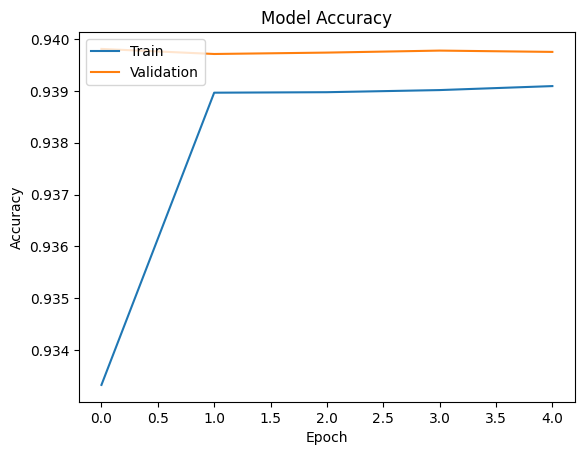

In [160]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

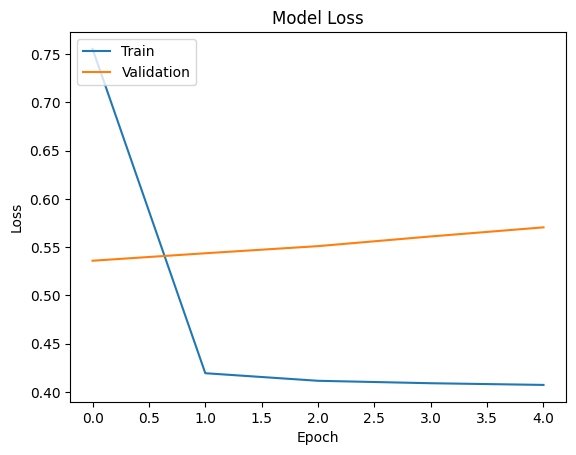

In [161]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


In [288]:

def Model_ready_input(text):
  text=str(text)
  text=Normalize_Input(text)
  text_sequence = tokenizer.texts_to_sequences([text])
  text_padded = pad_sequences(text_sequence, maxlen=max_length, truncating=trunc_type)
  return text_padded


##Simple RNN  Result on test dataset  

---
accuracy: 0.8931 - loss: 0.8018


In [163]:
model.evaluate(test_padded,padded_test_labels)


93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.9364 - loss: 0.6235


[0.6053740978240967, 0.9382546544075012]

#Translating english to urdu

In [165]:
def translate_english_to_urdu(input_text):
    # Step 1: Preprocess the input
    input_text = str(input_text)  # Ensure it's a string
    input_sequence = tokenizer.texts_to_sequences([input_text])  # Tokenize the input text
    input_padded = pad_sequences(input_sequence, maxlen=max_length, truncating=trunc_type)  # Pad the sequence

    # Step 2: Predict the Urdu sequence
    prediction = model.predict(input_padded)  # Get the model's output (predicted token indices)

    # Step 3: Post-process the prediction
    # Get the index of the word with the highest probability at each time step
    predicted_sequence = np.argmax(prediction, axis=-1)[0]  # Take the first sequence in the batch

    # Step 4: Convert the predicted token indices back to words
    urdu_translation = ''
    for token in predicted_sequence:
        if token != 0:  # Skip padding tokens
            word = tokenizer.index_word.get(token, '<OOV>')  # Convert index to word, or OOV if not found
            urdu_translation += word + ' '

    return urdu_translation.strip()  # Return the final translation

# Example usage:
english_input = "How are you?"
urdu_output = translate_english_to_urdu(english_input)
print(f"Input: {english_input} => Predicted Urdu Translation: {urdu_output}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Input: How are you? => Predicted Urdu Translation: <OOV> <OOV>


##Testing on small dataset

In [297]:
import pandas as pd

# Create a DataFrame with 100 sentences
data = {
    'english': [
        "Hello, how are you?",
        "What is your name?",
        "I am learning.",
        "Where do you live?",
        "It is a beautiful day.",
        "I love reading books.",
        "How old are you?",
        "This is my favorite movie.",
        "Can you help me?",
        "Thank you very much!",
        "What time is it?",
        "I am feeling happy today.",
        "The weather is nice.",
        "Where are you going?",
        "I want to learn more.",
        "Do you speak English?",
        "She is my best friend.",
        "Can I get some water?",
        "I will meet you tomorrow.",
        "Please close the door.",
        "Where is the nearest restaurant?",
        "This is a difficult problem.",
        "I have a question for you.",
        "Can we go out tonight?",
        "He is a good person.",
        "I forgot my phone at home.",
        "We are having dinner now.",
        "I enjoy listening to music.",
        "The book was very interesting.",
        "He works in a big company.",
        "I am very tired today.",
        "Do you know the answer?",
        "I hope you have a good day.",
        "What is the price of this?",
        "She sings beautifully.",
        "We are going to the market.",
        "Can I borrow your pen?",
        "I am waiting for the bus.",
        "What did you say?",
        "I am studying for my exams.",
        "The food is very tasty.",
        "I am going to the gym.",
        "Where is your brother?",
        "I am watching a movie.",
        "Please pass me the salt.",
        "The baby is sleeping.",
        "It is raining outside.",
        "He is my younger brother.",
        "I need some help with this.",
        "I am visiting my grandparents.",
        "She is wearing a red dress.",
        "I will be back soon.",
        "Are you coming to the party?",
        "The meeting is at 10 AM.",
        "I am going on a trip next week.",
        "The flowers are beautiful.",
        "I need to go to the bank.",
        "The sun is shining brightly.",
        "I will call you later.",
        "She is reading a book.",
        "We are going on vacation.",
        "The car is parked outside.",
        "I like playing football.",
        "The house is very big.",
        "I am cooking dinner.",
        "The sky is clear today.",
        "I lost my wallet.",
        "The cake is delicious.",
        "Can you come with me?",
        "I need to buy some groceries.",
        "She is talking to her friend.",
        "The cat is sitting on the chair.",
        "I am learning a new language.",
        "He is writing a letter.",
        "I am going to bed now.",
        "Please turn off the lights.",
        "I need to finish my homework.",
        "We are going to the park.",
        "I am working on a project.",
        "The children are playing outside.",
        "She is baking a cake.",
        "I am looking for my keys.",
        "The train is arriving soon.",
        "The meeting has been canceled.",
        "Can you lend me some money?",
        "I am planning a party.",
        "The dog is barking loudly.",
        "She is wearing glasses.",
        "I am cleaning the house.",
        "The news is very important.",
        "We are going to the beach.",
        "I am feeling a little sick.",
        "The exam was difficult.",
        "I am going to visit a friend.",
        "The street is very busy.",
        "I have finished my work.",
        "I am going to the doctor.",
        "The plane is taking off.",
        "I am sending an email.",
        "He is driving the car.",
        "We are moving to a new house.",
        "The restaurant is very crowded.",
        "I am learning to play the guitar.",
        "I am going to the library.",
        "He is swimming in the pool."
    ],
    'urdu': [
        "ہیلو، آپ کیسے ہیں؟",
        "آپ کا نام کیا ہے؟",
        "میں سیکھ رہا ہوں۔",
        "آپ کہاں رہتے ہیں؟",
        "یہ ایک خوبصورت دن ہے۔",
        "مجھے کتابیں پڑھنا پسند ہے۔",
        "آپ کی عمر کیا ہے؟",
        "یہ میری پسندیدہ فلم ہے۔",
        "کیا آپ میری مدد کر سکتے ہیں؟",
        "آپ کا بہت شکریہ!",
        "کتنا وقت ہوا ہے؟",
        "آج میں خوش محسوس کر رہا ہوں۔",
        "موسم اچھا ہے۔",
        "آپ کہاں جا رہے ہیں؟",
        "میں مزید سیکھنا چاہتا ہوں۔",
        "کیا آپ انگریزی بولتے ہیں؟",
        "وہ میری بہترین دوست ہے۔",
        "کیا مجھے کچھ پانی مل سکتا ہے؟",
        "میں کل آپ سے ملوں گا۔",
        "براہ کرم دروازہ بند کر دیں۔",
        "سب سے قریبی ریستوران کہاں ہے؟",
        "یہ ایک مشکل مسئلہ ہے۔",
        "میرے پاس آپ کے لئے ایک سوال ہے۔",
        "کیا ہم آج رات باہر جا سکتے ہیں؟",
        "وہ ایک اچھا انسان ہے۔",
        "میں نے اپنا فون گھر بھول گیا ہوں۔",
        "ہم ابھی رات کا کھانا کھا رہے ہیں۔",
        "مجھے موسیقی سننا پسند ہے۔",
        "یہ کتاب بہت دلچسپ تھی۔",
        "وہ ایک بڑی کمپنی میں کام کرتا ہے۔",
        "آج میں بہت تھکا ہوا ہوں۔",
        "کیا آپ جواب جانتے ہیں؟",
        "میں امید کرتا ہوں کہ آپ کا دن اچھا گزرے۔",
        "اس کی قیمت کیا ہے؟",
        "وہ بہت خوبصورت گاتی ہے۔",
        "ہم بازار جا رہے ہیں۔",
        "کیا میں آپ کا قلم لے سکتا ہوں؟",
        "میں بس کے انتظار میں ہوں۔",
        "آپ نے کیا کہا؟",
        "میں اپنے امتحانات کی تیاری کر رہا ہوں۔",
        "کھانا بہت لذیذ ہے۔",
        "میں جم جا رہا ہوں۔",
        "آپ کا بھائی کہاں ہے؟",
        "میں فلم دیکھ رہا ہوں۔",
        "براہ کرم مجھے نمک دے دیں۔",
        "بچہ سو رہا ہے۔",
        "باہر بارش ہو رہی ہے۔",
        "وہ میرا چھوٹا بھائی ہے۔",
        "مجھے اس میں کچھ مدد کی ضرورت ہے۔",
        "میں اپنے دادا دادی سے ملنے جا رہا ہوں۔",
        "وہ ایک سرخ لباس پہنی ہوئی ہے۔",
        "میں جلد واپس آؤں گا۔",
        "کیا آپ پارٹی میں آ رہے ہیں؟",
        "میٹنگ صبح 10 بجے ہے۔",
        "میں اگلے ہفتے ایک سفر پر جا رہا ہوں۔",
        "پھول بہت خوبصورت ہیں۔",
        "مجھے بینک جانا ہے۔",
        "سورج چمک رہا ہے۔",
        "میں بعد میں آپ کو کال کروں گا۔",
        "وہ کتاب پڑھ رہی ہے۔",
        "ہم چھٹی پر جا رہے ہیں۔",
        "گاڑی باہر کھڑی ہے۔",
        "مجھے فٹ بال کھیلنا پسند ہے۔",
        "گھر بہت بڑا ہے۔",
        "میں رات کا کھانا بنا رہا ہوں۔",
        "آج آسمان صاف ہے۔",
        "میں نے اپنا بٹوہ کھو دیا ہے۔",
        "کیک بہت مزیدار ہے۔",
        "کیا آپ میرے ساتھ آ سکتے ہیں؟",
        "مجھے کچھ سودا سلف خریدنے کی ضرورت ہے۔",
        "وہ اپنی دوست سے بات کر رہی ہے۔",
        "بلی کرسی پر بیٹھی ہے۔",
        "میں ایک نئی زبان سیکھ رہا ہوں۔",
        "وہ ایک خط لکھ رہا ہے۔",
        "میں اب سونے جا رہا ہوں۔",
        "براہ کرم لائٹس بند کر دیں۔",
        "مجھے اپنا ہوم ورک مکمل کرنا ہے۔",
        "ہم پارک جا رہے ہیں۔",
        "میں ایک منصوبے پر کام کر رہا ہوں۔",
        "بچے باہر کھیل رہے ہیں۔",
        "وہ کیک بنا رہی ہے۔",
        "میں اپنی چابیاں تلاش کر رہا ہوں۔",
        "ٹرین جلد ہی پہنچ رہی ہے۔",
        "میٹنگ منسوخ کر دی گئی ہے۔",
        "کیا آپ مجھے کچھ پیسے دے سکتے ہیں؟",
        "میں ایک پارٹی کی منصوبہ بندی کر رہا ہوں۔",
        "کتا زور سے بھونک رہا ہے۔",
        "وہ عینک پہنے ہوئے ہے۔",
        "میں گھر کی صفائی کر رہا ہوں۔",
        "خبریں بہت اہم ہیں۔",
        "ہم سمندر کنارے جا رہے ہیں۔",
        "مجھے تھوڑا سا بیمار محسوس ہو رہا ہے۔",
        "امتحان مشکل تھا۔",
        "میں ایک دوست سے ملنے جا رہا ہوں۔",
        "سڑک بہت مصروف ہے۔",
        "میں نے اپنا کام مکمل کر لیا ہے۔",
        "میں ڈاکٹر کے پاس جا رہا ہوں۔",
        "جہاز اڑان بھر رہا ہے۔",
        "میں ای میل بھیج رہا ہوں۔",
        "وہ گاڑی چلا رہا ہے۔",
        "ہم ایک نئے گھر میں منتقل ہو رہے ہیں۔",
        "ریستوران بہت بھیڑ بھرا ہے۔",
        "میں گٹار سیکھ رہا ہوں۔",
        "میں لائبریری جا رہا ہوں۔",
        "وہ سوئمنگ پول میں تیر رہا ہے۔"
    ]
}

df = pd.DataFrame(data)

# Save to CSV
df.to_csv('english_urdu_corpus_100.csv', index=False)


In [298]:
df.head()

,english,urdu
0,"Hello, how are you?",ہیلو، آپ کیسے ہیں؟
1,What is your name?,آپ کا نام کیا ہے؟
2,I am learning.,میں سیکھ رہا ہوں۔
3,Where do you live?,آپ کہاں رہتے ہیں؟
4,It is a beautiful day.,یہ ایک خوبصورت دن ہے۔


In [299]:
df['english']=df['english'].apply(Normalize_Input)
df['urdu']=df['urdu'].apply(Normalize_label)

In [300]:
train,val,test=np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [301]:
vocab_size=10000
embedding_dim=50
max_length=200
trunc_type='post'
oov_tok='<OOV>'
train_inputs=train['english'].values
val_inputs=val['english'].values
test_inputs=test['english'].values


val_inputs_str=[str(x) for x in val_inputs]
test_inputs_str=[str(x) for x in test_inputs]
train_inputs_str = [str(x) for x in train_inputs]


#tokenization of input (english sentences)
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(train_inputs_str)

#vectorization of input

train_sequences = tokenizer.texts_to_sequences(train_inputs_str)
val_sequences = tokenizer.texts_to_sequences(val_inputs_str)
test_sequences = tokenizer.texts_to_sequences(test_inputs_str)

#Pad the sequences to ensure equal length
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)
val_padded = pad_sequences(val_sequences, maxlen=max_length, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)


In [302]:
train_labels=train['urdu'].values
train_labels = [str(x) for x in train_labels]
# tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(train_labels)
train_labels_sequences = tokenizer.texts_to_sequences(train_labels)
padded_train_labels = pad_sequences(train_labels_sequences, maxlen=max_length, truncating=trunc_type)

In [303]:
val_labels=val['urdu'].values
val_labels = [str(x) for x in val_labels]
# tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(val_labels)
val_labels_sequences = tokenizer.texts_to_sequences(val_labels)
padded_val_labels = pad_sequences(val_labels_sequences, maxlen=max_length, truncating=trunc_type)

In [304]:
test_labels=test['urdu'].values
test_labels = [str(x) for x in test_labels]
# tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(test_labels)
test_labels_sequences = tokenizer.texts_to_sequences(test_labels)
padded_test_labels = pad_sequences(test_labels_sequences, maxlen=max_length, truncating=trunc_type)

In [305]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),



    tf.keras.layers.Dense(128, activation='tanh'),

    # First LSTM layer
    tf.keras.layers.LSTM(64, return_sequences=True),

    # Second LSTM layer
    tf.keras.layers.LSTM(128, return_sequences=True),

    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

    # Output layer for vocabulary size
    tf.keras.layers.Dense(vocab_size, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [307]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_padded,
    np.expand_dims(padded_train_labels, -1),
    batch_size=32,
    epochs=100,
    validation_data=(val_padded, padded_val_labels),
    callbacks=[early_stopping]
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9646 - loss: 0.8391 - val_accuracy: 0.9695 - val_loss: 0.7896
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9643 - loss: 0.7977 - val_accuracy: 0.9695 - val_loss: 0.7541
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9648 - loss: 0.7582 - val_accuracy: 0.9695 - val_loss: 0.7252
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9645 - loss: 0.7330 - val_accuracy: 0.9695 - val_loss: 0.7013
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9637 - loss: 0.7138 - val_accuracy: 0.9695 - val_loss: 0.6810
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9650 - loss: 0.6827 - val_accuracy: 0.9695 - val_loss: 0.6634
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9647 - loss: 0.6671 - val_accuracy: 0.9695 - val_loss: 0.6480
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9647 - loss: 0.6500 - val_accuracy: 0.9695 - val_loss: 0.6342
Epoc

In [201]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.SimpleRNN(128, return_sequences=True),  # Simple RNN layer
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    # Another Simple RNN layer
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
    # tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax'))  # Output layer for each time step
])

In [202]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [308]:
model.evaluate(test_padded,padded_test_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9709 - loss: 0.3697


[0.3697379231452942, 0.9709091186523438]

In [310]:
def translate_english_to_urdu(input_text):
    # Step 1: Preprocess the input
    input_text = str(input_text)  # Ensure it's a string
    input_sequence = tokenizer.texts_to_sequences([input_text])  # Tokenize the input text
    input_padded = pad_sequences(input_sequence, maxlen=max_length, truncating=trunc_type)  # Pad the sequence

    # Step 2: Predict the Urdu sequence
    prediction = model.predict(input_padded)  # Get the model's output (predicted token indices)

    # Step 3: Post-process the prediction
    # Get the index of the word with the highest probability at each time step
    predicted_sequence = np.argmax(prediction, axis=-1)[0]  # Take the first sequence in the batch

    # Step 4: Convert the predicted token indices back to words
    urdu_translation = ''
    for token in predicted_sequence:
        if token != 0:  # Skip padding tokens
            word = tokenizer.index_word.get(token, '<OOV>')  # Convert index to word, or OOV if not found
            urdu_translation += word + ' '

    return urdu_translation.strip()  # Return the final translation

# Example usage:
english_input = "what are you doing?"
urdu_output = translate_english_to_urdu(english_input)
print(f"Input: {english_input} => Predicted Urdu Translation: {urdu_output}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Input: what are you doing? => Predicted Urdu Translation: 
